# Predictive Maintenance using Machine Learning on Sagemaker
*Part 3 - Model training*

## Initialization
---
Directory structure to run this notebook:
```
sagemaker-predictive-maintenance
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
```

### Loading data from the previous notebook

In [2]:
%store -r

### Imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import sagemaker
import pickle as pkl
import boto3

from sagemaker.amazon.amazon_estimator import get_image_uri

from datetime import datetime
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sns.set_style('darkgrid')

### Get general information about this SageMaker session

In [5]:
role = sagemaker.get_execution_role()
session = sagemaker.Session()
bucket_name = session.default_bucket()
region = boto3.Session().region_name
prefix = 'nasa_engine_data'

### Set random seed
This will fix the random behavior of all this notebook to ease reproducibility. **Remove this in a production setting.**

In [6]:
import random
random.seed(42)

## Preparing training and validation data
---
As a first step, **we will consider each measurement as an independant event**, irregardless of the unit on which the measure took place. We will not consider this as a timeseries analysis and the question we want to answer to is the following:

> Given a set of sensor measurements and operation settings, how many cycles does the engine has left (estimating the `rul` column)?

Obviously, this is a big approximation as engine wear down is progressive and each timestep depends from the past behavior measured. We will explore this in a subsequent notebook dedicated to timeseries analysis with services like SageMaker DeepAR built-in algorithm or Amazon Forecast.

### Splitting data

In [9]:
# Extract the features (and convert them to float64 to prevent 
# warning from the scalign step later on) and the target dataframes:
X = data.loc[:, 'operational_setting_1':'sensor_measurement_21'].astype(np.float64)
y = data.loc[:, 'rul']

# Splitting training and validation data:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

### Normalizing data
Normalizing the features as they have wildly different ranges. We only need to scale the features as the target can only take two values (0 or 1):

In [10]:
# We build a scaler from the training dataset and apply the same 
# scaler to the validation one. Pay attention that scaling will 
# yield numpy arrays and not Pandas dataframes:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_val_scaled = pd.DataFrame(scaler.fit_transform(X_val))
y_train = pd.DataFrame(y_train).reset_index(drop=True)
y_val = pd.DataFrame(y_val).reset_index(drop=True)

# This exact same scaler will have to be used again on the testing 
# data before feeding them to the model. Let's persist it on S3:
joblib.dump(scaler, 'MinMaxScaler.joblib')
session.upload_data(path='MinMaxScaler.joblib', bucket=bucket_name, key_prefix='{}/preprocessing'.format(prefix))

's3://sagemaker-eu-west-1-123031033346/nasa_engine_data/preprocessing/MinMaxScaler.joblib'

### Uploading to S3

The XGBoost algorithm we want to use needs a dataset with the **target values in the first column** and the features in the remaining ones. Moreover, we want to **remove any header or index** from the dataframe. Let's assemble our training and validation datasets like this before uploading them to S3:

In [11]:
pd.concat([y_train, X_train_scaled], axis='columns').to_csv('training.csv', header=False, index=False)
pd.concat([y_val, X_val_scaled], axis='columns').to_csv('validation.csv', header=False, index=False)
session.upload_data(path='training.csv', bucket=bucket_name, key_prefix='{}/input'.format(prefix));
session.upload_data(path='validation.csv', bucket=bucket_name, key_prefix='{}/input'.format(prefix));

## Model training
---
Encapsulating inputs in S3 object to ensure content type (text/csv in this case) is correctly identified by the algorithm:

In [12]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/input/training.csv'.format(bucket_name, prefix), content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/input/validation.csv'.format(bucket_name, prefix), content_type='text/csv')

Build an `Estimator` object that will be used to train the model afterward:

In [14]:
# Fetch the training container for SageMaker built-in XGBoost algorithm:
xgb_container = get_image_uri(region, 'xgboost', '0.90-1')

# Build a training job name:
training_job_name = 'xgboost-model-v1-small-instance'

# Build the estimator object:
model_artifacts_path = 's3://{}/{}/output'.format(bucket_name, prefix)
xgb_estimator = sagemaker.estimator.Estimator(
    image_name=xgb_container,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    output_path=model_artifacts_path,
    sagemaker_session=session,
    base_job_name=training_job_name
)

# Link hyperparameters to this estimator:
xgb_estimator.set_hyperparameters(
    max_depth=6,
    eta=0.2,
    gamma=5,
    min_child_weight=6,
    subsample=0.9,
    silent=0,
    objective='reg:squarederror',
    num_round=40
)

Launch training:

In [15]:
xgb_estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-05-11 12:00:59 Starting - Starting the training job...
2020-05-11 12:01:01 Starting - Launching requested ML instances...
2020-05-11 12:01:59 Starting - Preparing the instances for training......
2020-05-11 12:02:44 Downloading - Downloading input data......
2020-05-11 12:03:54 Training - Downloading the training image...
2020-05-11 12:04:24 Uploading - Uploading generated training model
2020-05-11 12:04:24 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[12:04:13] 16504x17 matrix wi

### Plot training metrics
The metrics are stored in the Amazon Cloudwatch Logs service.

In [18]:
# Gets a Cloudwatch logs client:
cwlogs_client = boto3.client('logs')

# Each training has its log stored in a given log stream under the TrainingJobs logs group:
response = cwlogs_client.describe_log_streams(
    logGroupName='/aws/sagemaker/TrainingJobs',
    logStreamNamePrefix=training_job_name,
)
training_log_stream_name = response['logStreams'][0]['logStreamName']

# We can then get the events from this particular log stream:
response = cwlogs_client.get_log_events(
    logGroupName='/aws/sagemaker/TrainingJobs',
    logStreamName=training_log_stream_name,
    startFromHead=True
)

# Process the event logs to get the detailed train and validation metrics:
metrics_df = pd.DataFrame(columns=['train:rmse', 'validation:rmse'])
for event in response['events']:
    message = event['message'].split('#')
    if (len(message) > 1):
        train_rmse = float(message[1][14:])
        validation_rmse = float(message[2][19:])
        timestamp = datetime.fromtimestamp(float(event['timestamp'])/1000)
        
        metrics_df = metrics_df.append({'train:rmse': train_rmse, 'validation:rmse': validation_rmse}, ignore_index=True)

metrics_df.head()

,train:rmse,validation:rmse
0,105.7020,103.1410
1,88.4114,85.7857
2,75.1583,72.1567
3,65.1313,61.9541
4,57.6777,54.5083


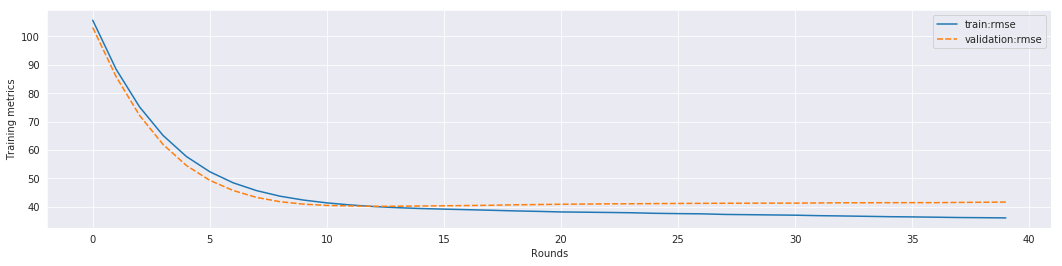

In [19]:
fig = plt.figure(figsize=(18,4))
chart = sns.lineplot(data=metrics_df)
chart.set_ylabel('Training metrics');
chart.set_xlabel('Rounds');

### Feature importance
To get the feature importance, we need to download first the model artifacts stored during the training on S3:

In [20]:
model_artifacts_key = 'nasa_engine_data/output/{}/output/model.tar.gz'.format(xgb_estimator._current_job_name)
print('Downloading model artifacts from s3://{}/{}'.format(bucket_name, model_artifacts_key))
s3_client = boto3.Session().resource('s3')
s3_client.Bucket(bucket_name).download_file(model_artifacts_key, 'model.tar.gz')
!tar -xzf model.tar.gz

XGBoost is installed in the training container we used previously. It is not installed by default on the notebook instance. Installing the open source XGBoost module (with the same version as the latest built-in SageMaker one):

In [21]:
!pip install xgboost==0.90

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Load the model into a booster object:

In [24]:
booster = pkl.load(open('xgboost-model', 'rb'))

Get feature importance from the XGBoost model:

In [25]:
fscores = booster.get_fscore()
feature_importance = pd.DataFrame(columns=['feature', 'score'])
for feature in fscores:
    index = int(feature[1:])
    feature_importance = feature_importance.append({
        'feature': X_train.columns.tolist()[index],
        'score': fscores[feature]
    }, ignore_index=True)
    
feature_importance = feature_importance.sort_values(by='score', ascending=False)

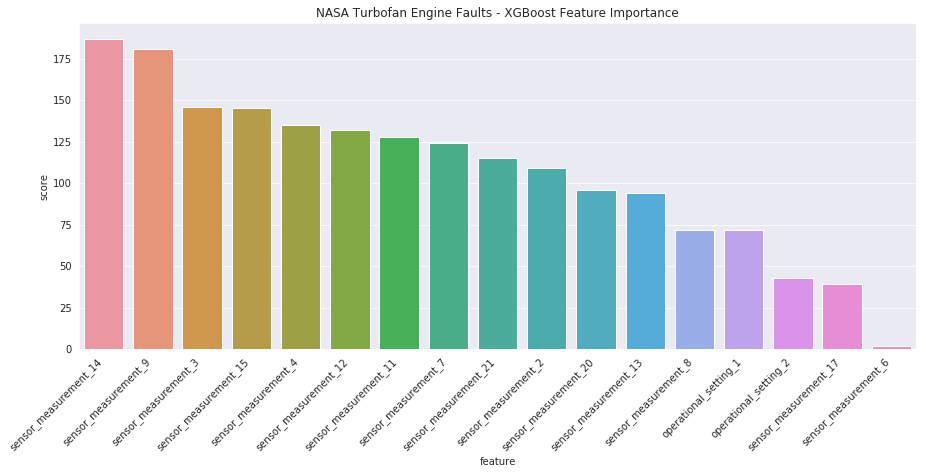

In [26]:
fig = plt.figure(figsize=(15,6))
chart = sns.barplot(x='feature', y='score', data=feature_importance)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');
chart.set_title('NASA Turbofan Engine Faults - XGBoost Feature Importance');

In [34]:
xgb_last_training_job = xgb_estimator.latest_training_job.name
%store X_train
%store xgb_last_training_job

Stored 'X_train' (DataFrame)
Stored 'xgb_last_training_job' (str)
